In [1]:
#Imports and Data Preparation
import pandas as pd
import numpy as np
import librosa
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.decomposition import NMF
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from IPython.display import Audio

data_path = pd.read_csv('data_path.csv')

In [2]:
# NMF-based Speech Emotion Recognition System

print("Starting NMF-based SER system...")

# Step 1: Extract mel spectrogram features from all audio files
def extract_mel_spectrogram_features(file_path, n_mels=128, n_fft=2048, hop_length=512):
    """
    Extract mel spectrogram features from an audio file.
    Returns flattened mel spectrogram as a feature vector.
    """
    try:
        y, sr = librosa.load(file_path, duration=3, offset=0.5)
        # Compute mel spectrogram
        mel_spec = librosa.feature.melspectrogram(
            y=y, 
            sr=sr, 
            n_mels=n_mels, 
            n_fft=n_fft, 
            hop_length=hop_length,
            fmax=8000
        )
        # Convert to dB scale
        mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
        # Flatten the spectrogram to create a feature vector
        # Using statistical aggregation for better dimensionality
        features = np.concatenate([
            np.mean(mel_spec_db, axis=1),  # Mean across time
            np.std(mel_spec_db, axis=1),   # Std across time
            np.max(mel_spec_db, axis=1),   # Max across time
            np.min(mel_spec_db, axis=1)    # Min across time
        ])
        return features
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return None

print("\nStep 1: Extracting mel spectrogram features from all audio files...")
X_features = []
y_labels = []
valid_indices = []

for idx, row in data_path.iterrows():
    features = extract_mel_spectrogram_features(row['Path'])
    if features is not None:
        X_features.append(features)
        y_labels.append(row['Emotions'])
        valid_indices.append(idx)

X_features = np.array(X_features)
y_labels = np.array(y_labels)

print(f"Extracted features from {len(X_features)} audio files")
print(f"Feature vector shape: {X_features.shape}")
print(f"Number of unique emotions: {len(np.unique(y_labels))}")
print(f"Emotions: {np.unique(y_labels)}")

# Step 2: Prepare data for NMF
# Normalize features to ensure non-negativity for NMF
print("\nStep 2: Preparing data for NMF...")
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_features)

# NMF requires non-negative input, so we shift to make all values non-negative
X_min = np.min(X_scaled)
X_nmf_input = X_scaled - X_min + 1e-10  # Add small epsilon to ensure positivity

print(f"NMF input shape: {X_nmf_input.shape}")
print(f"NMF input min: {np.min(X_nmf_input):.4f}, max: {np.max(X_nmf_input):.4f}")

# Encode emotion labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y_labels)
print(f"Encoded labels shape: {y_encoded.shape}")
print(f"Label mapping: {dict(zip(label_encoder.classes_, range(len(label_encoder.classes_))))}")

# Step 3: Split data into train and test sets
print("\nStep 3: Splitting data into train and test sets...")
X_train, X_test, y_train, y_test = train_test_split(
    X_nmf_input, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

print(f"Training set size: {X_train.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")
print(f"Training set emotion distribution:")
unique, counts = np.unique(y_train, return_counts=True)
for emotion, count in zip(label_encoder.inverse_transform(unique), counts):
    print(f"  {emotion}: {count}")


Starting NMF-based SER system...

Step 1: Extracting mel spectrogram features from all audio files...
Extracted features from 1440 audio files
Feature vector shape: (1440, 512)
Number of unique emotions: 8
Emotions: ['angry' 'calm' 'disgust' 'fear' 'happy' 'neutral' 'sad' 'surprise']

Step 2: Preparing data for NMF...
NMF input shape: (1440, 512)
NMF input min: 0.0000, max: 42.7709
Encoded labels shape: (1440,)
Label mapping: {'angry': 0, 'calm': 1, 'disgust': 2, 'fear': 3, 'happy': 4, 'neutral': 5, 'sad': 6, 'surprise': 7}

Step 3: Splitting data into train and test sets...
Training set size: 1152
Test set size: 288
Training set emotion distribution:
  angry: 154
  calm: 154
  disgust: 154
  fear: 153
  happy: 153
  neutral: 77
  sad: 154
  surprise: 153


In [3]:
# Step 4: Apply NMF decomposition
print("\nStep 4: Applying NMF decomposition...")
# Number of components
n_components = len(np.unique(y_encoded)) 

print(f"Number of NMF components: {n_components}")

# Apply NMF to training data
# Using basic parameters that work across sklearn versions
nmf = NMF(n_components=n_components, random_state=42, max_iter=1000)
W_train = nmf.fit_transform(X_train)  # W: basis matrix (n_samples x n_components)
H = nmf.components_  # H: coefficient matrix (n_components x n_features)

print(f"NMF W matrix shape (training): {W_train.shape}")
print(f"NMF H matrix shape (components): {H.shape}")
print(f"Reconstruction error: {nmf.reconstruction_err_:.4f}")

# Transform test data using the learned NMF model
W_test = nmf.transform(X_test)
print(f"NMF W matrix shape (test): {W_test.shape}")


Step 4: Applying NMF decomposition...
Number of NMF components: 8
NMF W matrix shape (training): (1152, 8)
NMF H matrix shape (components): (8, 512)
Reconstruction error: 452.3118
NMF W matrix shape (test): (288, 8)


In [4]:
# Step 5: Train classifiers on NMF features and evaluate
print("\nStep 5: Training classifiers on NMF features")

classifiers = {
    'Random Forest': RandomForestClassifier(
        n_estimators=50,
        random_state=42, 
        max_depth=5,  # Reduced to prevent overfitting
        min_samples_split=20,
        min_samples_leaf=10,
        max_features='sqrt'  # Use sqrt of features for each split
    ),
    'SVM': SVC(kernel='rbf', random_state=42, probability=True, C=1.0, gamma='scale'),
    'K-Nearest Neighbors': KNeighborsClassifier(n_neighbors=10)  # Increased neighbors for more regularization
}

results = {}

for name, clf in classifiers.items():
    print(f"\nTraining {name}...")
    # Train on NMF features
    clf.fit(W_train, y_train)
    
    # Predictions
    y_train_pred = clf.predict(W_train)
    y_test_pred = clf.predict(W_test)
    
    # Calculate accuracies
    train_acc = accuracy_score(y_train, y_train_pred)
    test_acc = accuracy_score(y_test, y_test_pred)
    
    results[name] = {
        'train_accuracy': train_acc,
        'test_accuracy': test_acc,
        'y_test_pred': y_test_pred,
        'classifier': clf
    }
    
    overfitting_gap = train_acc - test_acc
    print(f"  Training Accuracy: {train_acc:.4f} ({train_acc*100:.2f}%)")
    print(f"  Test Accuracy: {test_acc:.4f} ({test_acc*100:.2f}%)")

best_classifier = max(results.items(), key=lambda x: x[1]['test_accuracy'])
print(f"\nBest Classifier: {best_classifier[0]} with Test Accuracy: {best_classifier[1]['test_accuracy']:.4f} ({best_classifier[1]['test_accuracy']*100:.2f}%)")



Step 5: Training classifiers on NMF features

Training Random Forest...
  Training Accuracy: 0.5312 (53.12%)
  Test Accuracy: 0.2812 (28.12%)

Training SVM...
  Training Accuracy: 0.3542 (35.42%)
  Test Accuracy: 0.2778 (27.78%)

Training K-Nearest Neighbors...
  Training Accuracy: 0.4505 (45.05%)
  Test Accuracy: 0.2917 (29.17%)

Best Classifier: K-Nearest Neighbors with Test Accuracy: 0.2917 (29.17%)



Per-Emotion Classification Table for K-Nearest Neighbors:


,precision,recall,f1-score,support,accuracy
angry,0.3158,0.4737,0.3789,38,0.4737
calm,0.3014,0.5789,0.3964,38,0.5789
disgust,0.2500,0.2105,0.2286,38,0.2105
fear,0.3500,0.1795,0.2373,39,0.1795
happy,0.3143,0.2821,0.2973,39,0.2821
neutral,0.3077,0.2105,0.2500,19,0.2105
sad,0.2500,0.1579,0.1935,38,0.1579
surprise,0.2353,0.2051,0.2192,39,0.2051



Confusion Matrix for K-Nearest Neighbors:


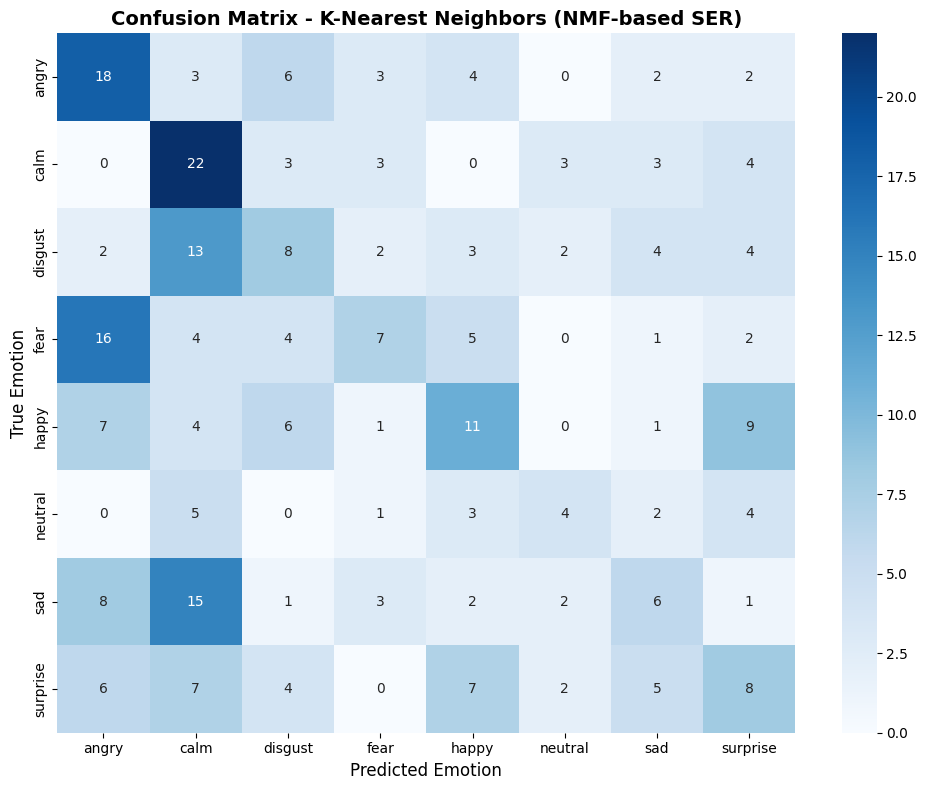

In [5]:
# Generate detailed classification report for best classifier (per-emotion table)
best_name = best_classifier[0]
best_pred = best_classifier[1]['y_test_pred']

# Build classification report dict and convert to DataFrame
report_dict = classification_report(y_test, best_pred, target_names=label_encoder.classes_, output_dict=True)
classes = list(label_encoder.classes_)
# Assemble DataFrame only for the emotion classes
report_df = pd.DataFrame({c: report_dict[c] for c in classes}).T
# Compute per-class accuracy (accuracy on the subset of samples of that class)
acc_list = []
for i, c in enumerate(classes):
    mask = (y_test == i)
    if np.sum(mask) > 0:
        acc = accuracy_score(y_test[mask], best_pred[mask])
    else:
        acc = np.nan
    acc_list.append(acc)
report_df['accuracy'] = acc_list
# # Nicely format support as integer and round floats
report_df['support'] = report_df['support'].astype(int)
report_df[['precision','recall','f1-score','accuracy']] = report_df[['precision','recall','f1-score','accuracy']].round(4)
print(f"\nPer-Emotion Classification Table for {best_name}:")
display(report_df)

# Confusion Matrix for best classifier
print(f"\nConfusion Matrix for {best_name}:")
cm = confusion_matrix(y_test, best_pred)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(
    cm, 
    annot=True, 
    fmt='d', 
    cmap='Blues',
    xticklabels=label_encoder.classes_,
    yticklabels=label_encoder.classes_
)
plt.title(f'Confusion Matrix - {best_name} (NMF-based SER)', fontsize=14, fontweight='bold')
plt.ylabel('True Emotion', fontsize=12)
plt.xlabel('Predicted Emotion', fontsize=12)
plt.tight_layout()
plt.show()
